## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install split-folders

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Import all library packages
import numpy as np
import pandas as pd
import json
import os
import shutil
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

from collections import Counter
from PIL import Image  # Import library PIL (Pillow)
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import splitfolders # Add this line to import the splitfolders library

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
import tensorflow.lite as tflite
import tensorflowjs as tfjs
from keras.regularizers import l2
from google.colab import files
from google.colab import drive
#drive.mount('/content/drive')
# Remove Warnings
warnings.filterwarnings("ignore")


## Data Preparation

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"agustinusalvinw","key":"7e59676807cf71efdf1c631807e0cf69"}'}

In [ ]:
# Membuat direktori .kaggle
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls -l /root/.kaggle/

total 4
-rw------- 1 root root 71 May 23 17:04 kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-image-dataset


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-image-dataset


In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset # Mengunduh dataset dari kaggle

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 96% 210M/219M [00:00<00:00, 646MB/s] 
100% 219M/219M [00:00<00:00, 654MB/s]


In [ ]:
!unzip /content/rice-image-dataset.zip -d dataset  # Mengekstrak dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: dataset/Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  in

In [ ]:
path = '/content/dataset/Rice_Image_Dataset'

In [ ]:
# Rapikan struktur folder (pindahkan file gambar ke direktori kelas langsung)
# dataset_dir = "Food Classification dataset" # Comment out or remove this line

# Use the path returned by kagglehub.dataset_download
dataset_dir = path

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src = os.path.join(root, file)
                    dst = os.path.join(class_path, file)
                    if src != dst:
                        shutil.move(src, dst)
        # Hapus subfolder kosong
        for root, dirs, _ in os.walk(class_path, topdown=False):
            for d in dirs:
                subfolder = os.path.join(root, d)
                if not os.listdir(subfolder):
                    os.rmdir(subfolder)
print("✅ Struktur folder berhasil dirapikan.")

✅ Struktur folder berhasil dirapikan.


In [ ]:
# Split: 70% train, 15% val, 15% test
# Update 'Animals' to the correct path of your dataset folder if needed
splitfolders.ratio('/content/dataset/Rice_Image_Dataset', output='output_dataset', seed=42, ratio=(.7, .15, .15))

Copying files: 75000 files [00:08, 8424.19 files/s]


In [ ]:
# Dataset sudah dalam format folder: output_dataset/train, output_dataset/val, output_dataset/test
train_dir = 'output_dataset/train'
val_dir = 'output_dataset/val'
test_dir = 'output_dataset/test'

img_size = (150, 150)
batch_size = 32


### Data Loading

In [ ]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images} /content/dataset/iran-used-cars-dataset")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"Error membuka {img_path}: {e}")

        print("Resolusi unik:")
        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
    print(f"\nTotal gambar: {total_images}")

In [ ]:
# Misalnya, kita cek resolusi pada folder '/train'
DATASET_PATH = '/content/output_dataset'  # pastikan path sesuai dengan struktur Anda
print("Cek resolusi gambar pada folder 'train':")
print_images_resolution(os.path.join(DATASET_PATH + '/train'))

Cek resolusi gambar pada folder 'train':
Ipsala: 10500 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Basmati: 10500 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Arborio: 10500 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Jasmine: 10500 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Karacadag: 10500 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------

Total gambar: 52500


In [ ]:
# Misalnya, kita cek resolusi pada folder '/valid'
DATASET_PATH = '/content/output_dataset'  # pastikan path sesuai dengan struktur Anda
print("Cek resolusi gambar pada folder 'val':")
print_images_resolution(os.path.join(DATASET_PATH, 'val'))

Cek resolusi gambar pada folder 'val':
Ipsala: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Basmati: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Arborio: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Jasmine: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Karacadag: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------

Total gambar: 11250


In [ ]:
# Misalnya, kita cek resolusi pada folder '/test'
DATASET_PATH = '/content/output_dataset'  # pastikan path sesuai dengan struktur Anda
print("Cek resolusi gambar pada folder 'test':")
print_images_resolution(os.path.join(DATASET_PATH, 'test'))

Cek resolusi gambar pada folder 'test':
Ipsala: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Basmati: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Arborio: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Jasmine: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------
Karacadag: 2250 /content/dataset/iran-used-cars-dataset
Resolusi unik:
- (250, 250)
---------------

Total gambar: 11250


In [ ]:
# total data yang akan digunakan
total_train = sum([len(files) for r, d, files in os.walk(DATASET_PATH + '/train')])
total_val = sum([len(files) for r, d, files in os.walk(DATASET_PATH + '/val')])
total_test = sum([len(files) for r, d, files in os.walk(DATASET_PATH + '/test')])
print(f"Total data latih: {total_train} gambar")
print(f"Total data validasi: {total_val} gambar")
print(f"Total data test: {total_test} gambar")
print(f"Total data keseluruhan: {total_train + total_val + total_test} gambar")

Total data latih: 52500 gambar
Total data validasi: 11250 gambar
Total data test: 11250 gambar
Total data keseluruhan: 75000 gambar


### Data Preprocessing

#### Split Dataset

In [ ]:
# Karena struktur dataset sudah terbagi menjadi train, valid, dan test, kita buat generator masing-masing
# Tentukan target size agar resolusi gambar seragam
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 52500 images belonging to 5 classes.


In [ ]:
# Data generator untuk validasi
valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'val'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 11250 images belonging to 5 classes.


In [ ]:
# Data generator untuk testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11250 images belonging to 5 classes.


## Modelling

In [ ]:
# Membangun Model CNN Dasar dengan Sequential
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 4
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,604,165 (13.75 MB)

 Trainable params: 3,602,693 (13.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Callback Implementation
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model_revised.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [ ]:
history = model.fit(
    train_generator,
    epochs=8,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7123 - loss: 0.8279
Epoch 1: val_accuracy improved from -inf to 0.88587, saving model to best_model_revised.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 332s 196ms/step - accuracy: 0.7124 - loss: 0.8276 - val_accuracy: 0.8859 - val_loss: 0.3208
Epoch 2/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9478 - loss: 0.1524
Epoch 2: val_accuracy improved from 0.88587 to 0.94213, saving model to best_model_revised.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 310s 189ms/step - accuracy: 0.9478 - loss: 0.1524 - val_accuracy: 0.9421 - val_loss: 0.1867
Epoch 3/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9701 - loss: 0.0905
Epoch 3: val_accuracy improved from 0.94213 to 0.96409, saving model to best_model_revised.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 310s 189ms/step - accuracy: 0.9701 - loss: 0.0905 - val_accuracy: 0.9641 - val_loss: 0.1138
Epoch 4/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9765 - loss: 0.0689
Epoch 4: val_accuracy improved from 0.96409 to 0.98053, saving model to best_model_revised.h5


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 309s 188ms/step - accuracy: 0.9765 - loss: 0.0689 - val_accuracy: 0.9805 - val_loss: 0.0590
Epoch 5/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9788 - loss: 0.0646
Epoch 5: val_accuracy did not improve from 0.98053
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 309s 188ms/step - accuracy: 0.9788 - loss: 0.0646 - val_accuracy: 0.8457 - val_loss: 0.6561
Epoch 6/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9822 - loss: 0.0530
Epoch 6: val_accuracy did not improve from 0.98053
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 313s 191ms/step - accuracy: 0.9822 - loss: 0.0530 - val_accuracy: 0.8985 - val_loss: 0.3300
Epoch 7/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9835 - loss: 0.0503
Epoch 7: val_accuracy did not improve from 0.98053
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 310s 189ms/step - accuracy: 0.9835 - loss: 0.0503 - val_accuracy: 0.7768 - val_loss: 0.9437
Epoch 8/8
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9850 - loss: 0.0459

## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi akurasi pada data training
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"Training accuracy: {train_acc*100:.2f}%")

# Evaluasi akurasi pada data testing
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test accuracy: {test_acc*100:.2f}%")


Training accuracy: 98.50%
Test accuracy: 97.66%


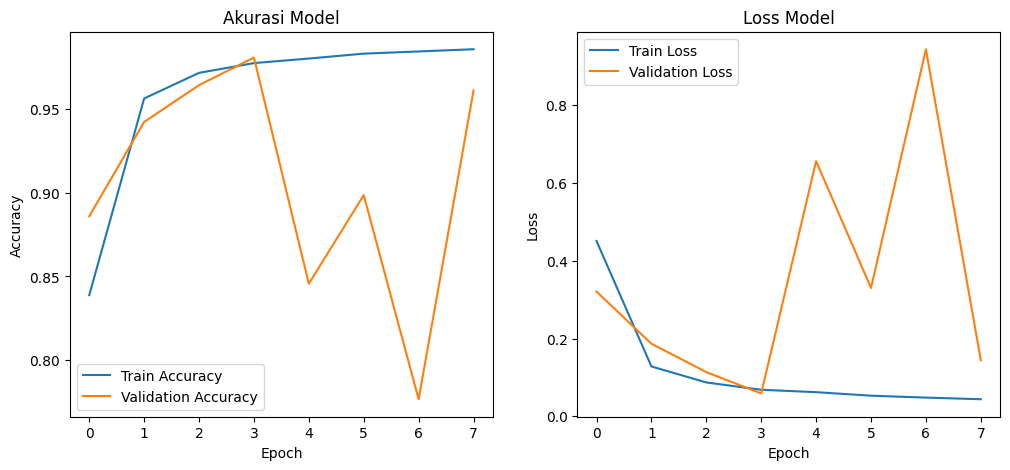

In [ ]:
# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [ ]:
# Simpan sebagai SavedModel
# ------------------------------
saved_model_dir = './saved_model/my_model'
tf.saved_model.save(model, saved_model_dir)

In [ ]:
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.experimental_new_converter = True # Use the new MLIR-based converter
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

tflite_dir = './tflite'
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

# Simpan file label.txt (misalnya dari train_generator.class_indices)
label_path = os.path.join(tflite_dir, 'label.txt')
with open(label_path, 'w') as f:
    for label, index in train_generator.class_indices.items():
        f.write(f"{index}:{label}\n")

print("Model berhasil disimpan sebagai SavedModel dan TF-Lite.")

Model berhasil disimpan sebagai SavedModel dan TF-Lite.


In [ ]:
# TFJS
!pip install tensorflowjs



In [ ]:
# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras best_model_revised.h5 tfjs_model

2025-05-23 17:52:07.499222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748022727.520242   15058 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748022727.526673   15058 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [ ]:

def load_and_preprocess_image(image_path, target_size=TARGET_SIZE):
    img = Image.open(image_path).resize(target_size)
    img = np.array(img) / 255.0
    if img.ndim == 2:
        img = np.stack((img,)*3, axis=-1)
    elif img.shape[-1] == 4:
        img = img[..., :3]
    return np.expand_dims(img.astype(np.float32), axis=0)

interpreter = tflite.Interpreter(model_path=os.path.join(tflite_dir, 'model.tflite'))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Coba aktifkan experimental_new_converter jika diperlukan:
converter.experimental_new_converter = True
# Ensure support for both built-in and select TensorFlow ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
# Perform the conversion
tflite_model = converter.convert()
with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpbiclvky_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133149103765648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149104974224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102315216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102317328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149104970768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102317136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102313680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102314064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133149102317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13314910231387

In [ ]:
# ipython-input-35-2e1a98cd6fe5

# Uji inference pada sample image (ubah path sesuai kebutuhan)
sample_image_path = os.path.join(DATASET_PATH, '/content/output_dataset/test/Basmati/basmati (10002).jpg')

# Initialize the interpreter AFTER the model has been converted and saved
interpreter = tflite.Interpreter(model_path=os.path.join(tflite_dir, 'model.tflite'))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


input_data = load_and_preprocess_image(sample_image_path)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

predictions = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(predictions[0])
print(f"Prediksi kelas untuk sample image: {predicted_class}")

print("Mapping label kelas:")
print(train_generator.class_indices)

Prediksi kelas untuk sample image: 1
Mapping label kelas:
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [ ]:
from google.colab import files
import shutil
import os

def download_folder_and_files(folder_path, download_name="downloaded_files.zip"):
  """Downloads the specified folder and its contents as a zip file.

  Args:
    folder_path: The path to the folder you want to download.
    download_name: The name of the zip file to create.
  """

  shutil.make_archive(download_name.split('.')[0], 'zip', folder_path)
  # Ensure files.download is called on the imported module
  files.download(download_name.split('.')[0] + '.zip')

# Specify the folder you want to download
folder_to_download = "/content/tflite"  # Replace with your desired folder

# Download the folder
download_folder_and_files(folder_to_download, "tflite_model.zip")


# Download the SavedModel folder
download_folder_and_files("/content/saved_model", "saved_model.zip")

# Download the tfjs_model folder
download_folder_and_files("/content/tfjs_model", "tfjs_model.zip")


# Download the best_model_revised.h5 file
# Ensure files.download is called on the imported module
files.download("best_model_revised.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def predict_image(model, image_path, class_names):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Membuat batch size 1
    img_array /= 255.  # Normalisasi seperti saat training

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class_name} ({confidence:.2f})")
    plt.axis('off')
    plt.show()